In [1]:
#Загрузка всех необходимых библиотек
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
import re
from statistics import mean
import optuna
!pip install arcgis
from arcgis.gis import GIS
from arcgis.geocoding import reverse_geocode
import optuna
from arcgis.geocoding import geocode
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from math import sqrt, atan2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
gis = GIS(profile="your_online_profile")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 71.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 6.9 MB/s eta 0:00:00
  Using cached lerc-0.1.0-py3-none-any.whl
  Using cached python_certifi_win32-1.6.1-py2.py3-none-any.whl (7.3 kB)
  Using cached geomet-1.0.0-py3-none-any.whl (28 kB)
  Using cached requests_toolbelt-0.10.1-py2.py3-none-any.whl (54 kB)
  Using cached requests_ntlm-1.1.0-py2.py3-none-any.whl (5.7 kB)
  Using cached requests_gssapi-1.2.3-py2.py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for arcgis: filename=arcgis-2.0.1-cp37-cp37m-linux_x86_64.whl size=833647

In [2]:
#Загружаем данные и сортируем колонки чтобы восстановить последовательность
df = pd.read_csv("../input/innopolis-data/train_dataset_train.csv")
df = df.reindex(sorted(df.columns), axis=1)
#Добавляем новые фичи - среднее по всем NDVI, максимальное среди всех NDVI и сумма всех NDVI. 
#Для этого временно удалим остальные колонки, предварительно сохранив их в переменные area, geo, crop (id не сохраняем - он не понадобится)
area = df["area"]
geo = df[".geo"]
crop = df["crop"]
df.drop(["id", "crop", ".geo", "area"], axis = 1, inplace = True)
df["mean_all"] = df.mean(axis=1)  
df["max_all"] = df.max(axis = 1)
df["sum_all"] = df.iloc[:,:70].sum(axis = 1)

#Возращаем нужные нам переменные area и geo обратно
df["area"] = area
df[".geo"] = geo
#Заранее создаем колонки для новых переменных 
#okrug - федеральных округ в котором расположен объект
df["okrug"] = 0
#region - регион в котором расположен объект
df["region"] = 0
#subregion - район в котором расположен объект
df["subregion"] = 0
#firstcoord - первая координата объекта (x)
df["firstcoord"] = 0.0
#secondcoord - вторая координата объекта (y)
df["secondcoord"] = 0.0
#ro и fi - полярные координаты точки (x,y)
df["fi"] = 0.0
df["ro"] = 0.0
#haversine - расстояние по формуле Гаверсинуса между координатами объекта и координатами района, в котором этот объект находится
df["haversine"] = 0.0
#peleng_angle - пеленг от координат объекта до координат района, в котором этот объект находится
df["peleng_angle"] = 0.0
#manhattan - расстояние по метрике Минковского между координатами объекта и координатами района, в котором этот объект находится
df["manhattan"] = 0.0
#river_count - число рек в пределах (x-0.3 : x+0.3, y-0.3 : y+0.3) от изначальных координат объекта (x,y)
df["river_count"] = 0
#farm_count - число ферм в пределах (x-0.3 : x+0.3, y-0.3 : y+0.3) от изначальных координат объекта (x,y)
df["farm_count"] = 0
#xrot15, yrot15 - преобразованные координаты при повороте системы координат на 15 градусов
df["xrot15"] = 0.0
df["yrot15"] = 0.0
#xrot30, yrot30 - преобразованные координаты при повороте системы координат на 30 градусов
df["xrot30"] = 0.0
df["yrot30"] = 0.0
#возращаем crop обратно в датафрейм
df["crop"] = crop

#Функция которая будет использоваться для получения координат объекта из переменной ".geo"
def remove_punct(text):
    return re.sub(r'[^0-9.,]', "", text)

#Функция которая будет использоваться для вычисления расстояния по формуле Гаверсинуса
def haversine_dist(x1,y1,x2,y2):
    x1, y1, x2, y2 = map(np.radians, (x1, y1, x2, y2)) 
    lat = x2 - x1
    lng = y2 - y1
    earth_radius = 6371 
    d = np.sin(lat/2) ** 2 + np.cos(x1) * np.cos(x2) * np.sin(lng/2) ** 2
    haversine = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return haversine

#Заполняем все новые переменные для каждого наблюдения в датафрейме
for i in range(len(df)):
    dictionary = remove_punct(df[".geo"][i]).split(",")
    dictionary = dictionary[:6]  #чтобы следующая строчка выполнялась быстрее
    dictionary = [x for x in dictionary if x != '']   #есть случай когда в dictionary попадает '', исключим этот случай
    dictionary = [float(x) for x in dictionary]
    coords = dictionary[:2]   #будем использовать только первую координату (x,y) объекта (остальные все равно расположены рядом)
    x = float(coords[0])
    y = float(coords[1])
    df["firstcoord"][i] = x
    df["secondcoord"][i] = y
    df["ro"][i] = sqrt((x**2) + (y**2))
    df["fi"][i] = atan2(y, x)
    df["xrot15"][i] = (0.965 * x) + (0.258 * y) #0.258 - sin(15degrees), 0.965 - cos(15degrees)
    df["yrot15"][i] = (0.965 * y) + (0.258 * x)
    df["xrot30"][i] = (0.866 * x) + (0.5 * y) #0.5 - sin(30degrees), 0.866 - cos(30degrees)
    df["yrot30"][i] = (0.866 * y) + (0.5 * x)
    results = reverse_geocode(coords)
    df["subregion"][i] = results["address"]["Subregion"]
    df["okrug"][i] = results["address"]["Territory"]
    df["region"][i] = results["address"]["Region"]
    if results["address"]["Subregion"] == '':   #есть случай когда subregion полученной координаты = '', в таком случае будем считать расстояние до region
        x_sub = geocode(results["address"]["Region"])[0]["location"]["x"]
        y_sub = geocode(results["address"]["Region"])[0]["location"]["y"]  #получаем координаты региона, в котором находится объект
        h = haversine_dist(x,y,x_sub,y_sub)
        df["haversine"][i] = h
        si = haversine_dist(x, y, x, y_sub)
        bi = haversine_dist(x, y, x_sub, y)
        df["manhattan"][i] = si + bi
        earth_radius = 6371  
        diff_lng = np.radians(y_sub - y)
        x1, y1, x2, y2 = map(np.radians, (x, y, x_sub, y_sub))
        y_peleng = np.sin(diff_lng) * np.cos(x2)
        x_peleng = np.cos(x1) * np.sin(x2) - np.sin(x1) * np.cos(x2) * np.cos(diff_lng)
        df["peleng_angle"][i] = np.degrees(np.arctan2(y_peleng, x_peleng))
    else:
        x_sub = geocode(results["address"]["Subregion"])[0]["location"]["x"]
        y_sub = geocode(results["address"]["Subregion"])[0]["location"]["y"]  #получаем координаты района, в котором находится объект
        h = haversine_dist(x,y,x_sub,y_sub)
        df["haversine"][i] = h
        si = haversine_dist(x, y, x, y_sub)
        bi = haversine_dist(x, y, x_sub, y)
        df["manhattan"][i] = si + bi
        earth_radius = 6371  
        diff_lng = np.radians(y_sub - y)
        x1, y1, x2, y2 = map(np.radians, (x, y, x_sub, y_sub))
        y_peleng = np.sin(diff_lng) * np.cos(x2)
        x_peleng = np.cos(x1) * np.sin(x2) - np.sin(x1) * np.cos(x2) * np.cos(diff_lng)
        df["peleng_angle"][i] = np.degrees(np.arctan2(y_peleng, x_peleng))
    search_area = { 'xmin': (x - 0.3),         #задаем пределы координат в которых будем искать реки и фермы
                       'ymin': (y - 0.3),  
                       'xmax': (x + 0.3),   
                       'ymax': (y + 0.3)
                       }

    rivers = geocode('River', search_extent=search_area, max_locations=40) #число рек
    df["river_count"][i] = len(rivers)
    farms = geocode('Farm', search_extent=search_area, max_locations=40)  #число ферм
    df["farm_count"][i] = len(farms)
    
#в результате было решено избавиться от "region" и "okrug", однако данные о них мы сохраним в датафрейме for_replace, который нам в дальнейшем понадобится  
for_replace = df[["okrug", "region", "subregion"]] 
df.drop([".geo", "okrug", "region"], axis = 1, inplace = True) #.geo тоже больше не нужно
X_train = df.iloc[:, :-1]
Y_train = df.iloc[:, -1]
#район зададим как категориальную переменную
cat_features_names = ["subregion"] 
cat_features = [X_train.columns.get_loc(col) for col in cat_features_names]
X_train["subregion"] = X_train["subregion"].astype("category")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to b

In [3]:
#Аналогичным образом загружаем и преобразовываем test 
test = pd.read_csv("../input/innopolis-data/test_dataset_test.csv")
test = test.reindex(sorted(test.columns), axis=1)
area = test["area"]
geo = test[".geo"]
test.drop(["id", ".geo", "area"], axis = 1, inplace = True)
test["mean_all"] = test.mean(axis=1)  
test["max_all"] = test.max(axis = 1)
test["sum_all"] = test.iloc[:,:70].sum(axis = 1)
test["area"] = area
test[".geo"] = geo
test["okrug"] = 0
test["region"] = 0
test["subregion"] = 0
test["firstcoord"] = 0.0
test["secondcoord"] = 0.0
test["fi"] = 0.0
test["ro"] = 0.0
test["haversine"] = 0.0
test["peleng_angle"] = 0.0
test["manhattan"] = 0.0
test["river_count"] = 0
test["farm_count"] = 0
test["xrot15"] = 0.0
test["yrot15"] = 0.0
test["xrot30"] = 0.0
test["yrot30"] = 0.0

for i in range(len(test)):
    dictionary = remove_punct(test[".geo"][i]).split(",")
    dictionary = dictionary[:6]  
    dictionary = [x for x in dictionary if x != '']   
    dictionary = [float(x) for x in dictionary]
    coords = dictionary[:2]   
    x = float(coords[0])
    y = float(coords[1])
    test["firstcoord"][i] = x
    test["secondcoord"][i] = y
    test["ro"][i] = sqrt((x**2) + (y**2))
    test["fi"][i] = atan2(y, x)
    test["xrot15"][i] = (0.965 * x) + (0.258 * y)
    test["yrot15"][i] = (0.965 * y) + (0.258 * x)
    test["xrot30"][i] = (0.866 * x) + (0.5 * y)
    test["yrot30"][i] = (0.866 * y) + (0.5 * x)
    results = reverse_geocode(coords)
    test["subregion"][i] = results["address"]["Subregion"]
    test["okrug"][i] = results["address"]["Territory"]
    test["region"][i] = results["address"]["Region"]
    if results["address"]["Subregion"] == '':   
        x_sub = geocode(results["address"]["Region"])[0]["location"]["x"]
        y_sub = geocode(results["address"]["Region"])[0]["location"]["y"]  
        h = haversine_dist(x,y,x_sub,y_sub)
        test["haversine"][i] = h
        si = haversine_dist(x, y, x, y_sub)
        bi = haversine_dist(x, y, x_sub, y)
        test["manhattan"][i] = si + bi
        earth_radius = 6371  
        diff_lng = np.radians(y_sub - y)
        x1, y1, x2, y2 = map(np.radians, (x, y, x_sub, y_sub))
        y_peleng = np.sin(diff_lng) * np.cos(x2)
        x_peleng = np.cos(x1) * np.sin(x2) - np.sin(x1) * np.cos(x2) * np.cos(diff_lng)
        test["peleng_angle"][i] = np.degrees(np.arctan2(y_peleng, x_peleng))
    else:
        x_sub = geocode(results["address"]["Subregion"])[0]["location"]["x"]
        y_sub = geocode(results["address"]["Subregion"])[0]["location"]["y"]  
        h = haversine_dist(x,y,x_sub,y_sub)
        test["haversine"][i] = h
        si = haversine_dist(x, y, x, y_sub)
        bi = haversine_dist(x, y, x_sub, y)
        test["manhattan"][i] = si + bi
        earth_radius = 6371  
        diff_lng = np.radians(y_sub - y)
        x1, y1, x2, y2 = map(np.radians, (x, y, x_sub, y_sub))
        y_peleng = np.sin(diff_lng) * np.cos(x2)
        x_peleng = np.cos(x1) * np.sin(x2) - np.sin(x1) * np.cos(x2) * np.cos(diff_lng)
        test["peleng_angle"][i] = np.degrees(np.arctan2(y_peleng, x_peleng))
    search_area = { 'xmin': (x - 0.3),         
                       'ymin': (y - 0.3),  
                       'xmax': (x + 0.3),   
                       'ymax': (y + 0.3)
                       }

    rivers = geocode('River', search_extent=search_area, max_locations=40) 
    test["river_count"][i] = len(rivers)
    farms = geocode('Farm', search_extent=search_area, max_locations=40)  
    test["farm_count"][i] = len(farms)

#районы, которые отсутствуют как категории в X_train. Их список был получен в результате ошибки при компиляции      
subregions_to_replace = ['Тонкинский район', 'Тугулымский район', 'Белокатайский район', 'Тюльганский район', 'Пучежский район', 'Куединский район', 'Сысертский район', 'Хлевенский район', 'Цильнинский район', 'Уренский район', 'Моркинский район', 'Абдулинский район', 'Глазуновский район', 'Пригородный район', 'Коломна', 'Чесменский район', 'Куйбышевский район', 'Захаровский район', 'Шемуршинский район', 'Серпухов']
#заменим каждый такой район на наиболее популярный район в том же регионе в X_train 
#(как раз для получения региона из X_train мы оставили for_replace на прошлом шаге)
for i in subregions_to_replace:
    try:
        region = test[test["subregion"] == i]["region"].values[0] #регион района, необходимого заменить
        to_repl = for_replace[for_replace["region"] == region]["subregion"].value_counts().index.values[0] #район для замены в том же регионе
        test.replace(i, to_repl, inplace = True)
    except IndexError: #если такого региона нет в X_train, то в качестве региона берем самый популярный - Воронежская область
        to_repl = for_replace[for_replace["region"] == "Воронежская область"]["subregion"].value_counts().index.values[0]
        test.replace(i, to_repl, inplace = True)

test.drop([".geo", "region", "okrug"], axis = 1, inplace = True)
test["subregion"] = test["subregion"].astype("category")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to b

In [4]:
#добавим в test и X_train еще 3 переменные:
#pca_x, pca_y - измененные в результате применения PCA координаты x,y (PCA обучается на всех данных: X_train + test)
#lbls - номер кластера в который попало наблюдение (всего 7 кластеров, обученных на всех данных: X_train + test)
for_concat = [X_train[["firstcoord", "secondcoord"]], test[["firstcoord", "secondcoord"]]]
frames_together = pd.concat(for_concat)
coordinates = frames_together[["firstcoord", "secondcoord"]].values
pca = PCA(random_state = 48, n_components = 2)
pca.fit(coordinates)
pca_x = pca.transform(X_train[["firstcoord", "secondcoord"]])[:,0]
pca_y = pca.transform(X_train[["firstcoord", "secondcoord"]])[:,1]
pca_x_test = pca.transform(test[["firstcoord", "secondcoord"]])[:,0]
pca_y_test = pca.transform(test[["firstcoord", "secondcoord"]])[:,1]
X_train["pca_x"] = pca_x
X_train["pca_y"] = pca_y
test["pca_x"] = pca_x_test
test["pca_y"] = pca_y_test
model = KMeans(n_clusters=7, random_state = 48)
model.fit(frames_together)
labels = model.predict(X_train[["firstcoord", "secondcoord"]])
labels_test = model.predict(test[["firstcoord", "secondcoord"]])
X_train["lbls"] = labels
test["lbls"] = labels_test

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [5]:
#Обучение модели (гиперпараметры best были получены c помощью поиска Optuna - код в файле Optuna.ipynb)
data_train = lgb.Dataset(X_train, label=Y_train)
best = {'lambda_l1': 3.349700803926709e-05, 'lambda_l2': 5.802117362638626e-06, 'num_leaves': 68, 'feature_fraction': 0.393011902347102, 'bagging_fraction': 0.7343289902404369, 'bagging_freq': 6, 'min_child_samples': 66}
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "num_classes": 7,
    "seed": 48} 
params.update(best)
lgbfit = lgb.train(params,
                   data_train,
                   categorical_feature=cat_features,
                   verbose_eval=False,                   
                   num_boost_round=11000,                    
                   callbacks=[lgb.reset_parameter(learning_rate = [0.005]*300 + [0.001]*7300 + [0.0005]*3400) ])

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [74]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [6]:
#Получаем прогнозы
probs = lgbfit.predict(test)
pred = [np.argmax(line) for line in probs]
sub = pd.read_csv("../input/innopolis-data/sample_solution.csv")
sub["crop"] = pred
sub.to_csv("my_submission_final.csv", index = False)  

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

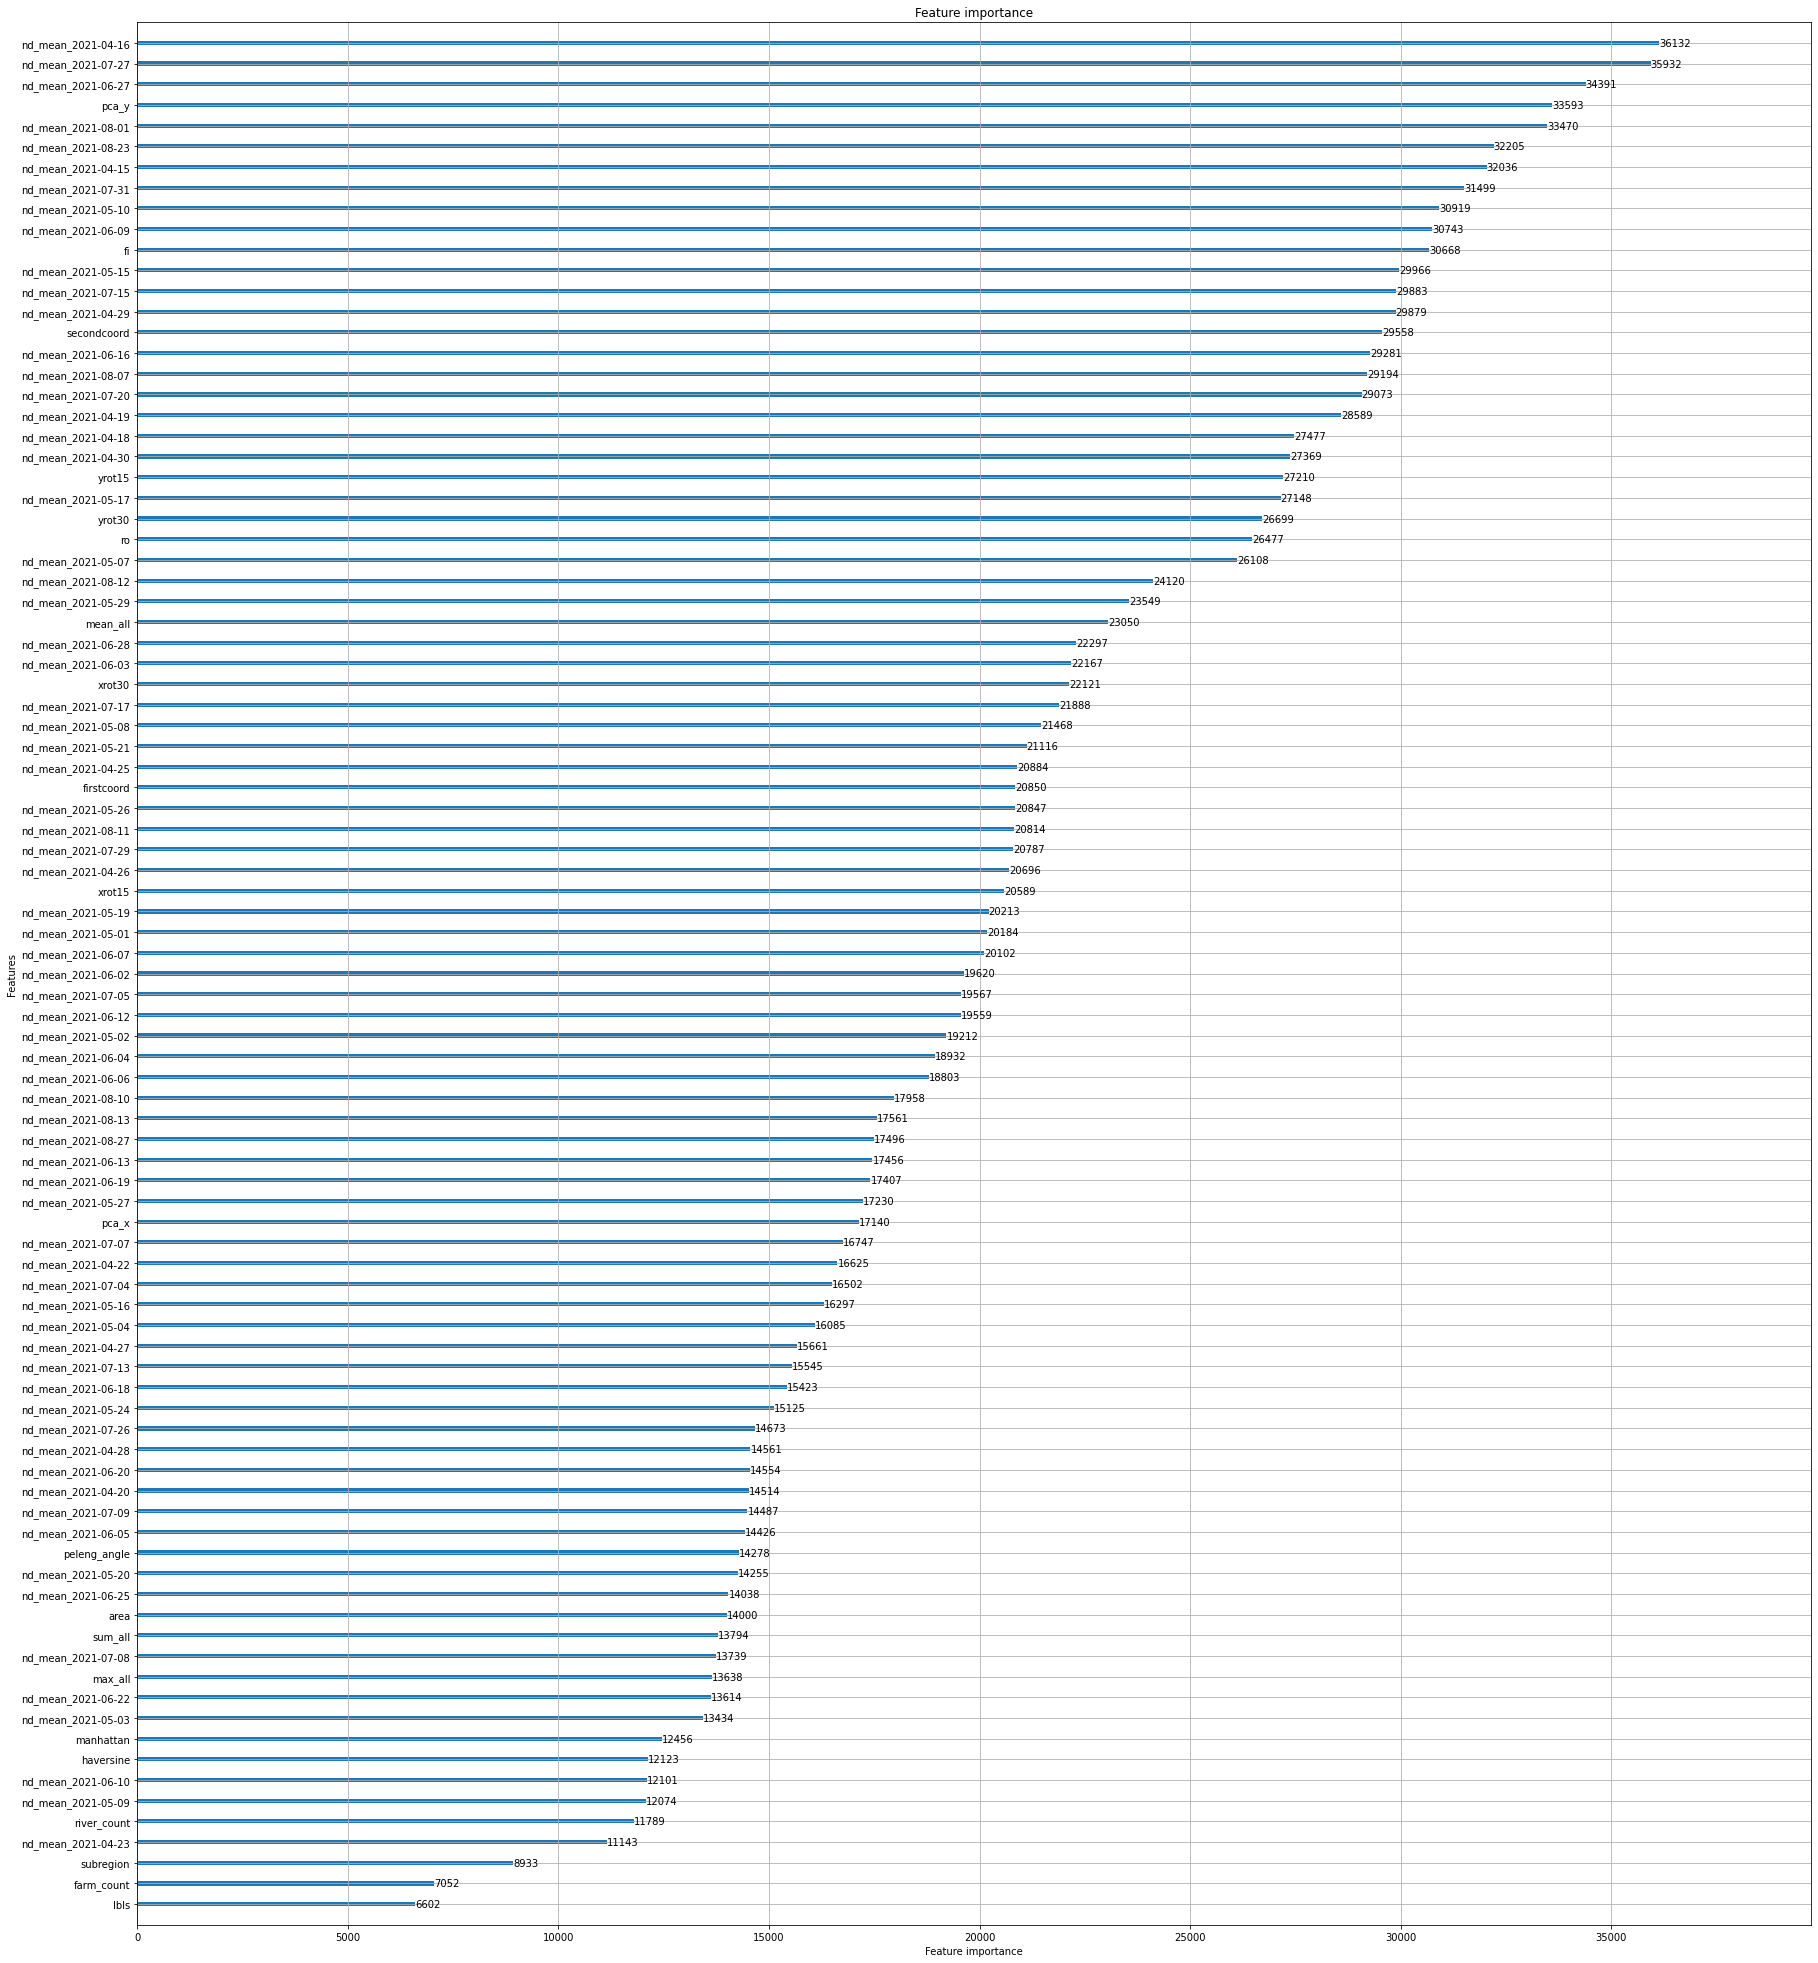

In [7]:
#Важность признаков
from lightgbm import plot_importance
plot_importance(lgbfit, figsize = (30,35))